In [20]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [13]:
data_path = "data"

# Cargar datos de ratings
ratings_file = os.path.join(data_path, 'ratings.dat')
ratings = pd.read_csv(ratings_file, sep='::',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'],
                      engine='python')

# Cargar datos de películas
movies_file = os.path.join(data_path, 'movies.dat')
movies = pd.read_csv(movies_file, sep='::',
                     names=['movie_id', 'title', 'genres'],
                     engine='python', encoding='latin-1')

# Cargar datos de usuarios
users_file = os.path.join(data_path, 'users.dat')
users = pd.read_csv(users_file, sep='::',
                    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'],
                    engine='python')

# Mostrar información básica de los datasets cargados
print("Dataset MovieLens 1M cargado correctamente")
print(f"Número de usuarios: {ratings['user_id'].nunique()}")
print(f"Número de películas: {ratings['movie_id'].nunique()}")
print(f"Número total de ratings: {len(ratings)}")
print(f"Rango de valoraciones: {ratings['rating'].min()} - {ratings['rating'].max()}")

# Ver las primeras filas de cada dataset
print("\nPrimeras 5 filas de ratings:")
print(ratings.head())

print("\nPrimeras 5 filas de películas:")
print(movies.head())

print("\nPrimeras 5 filas de usuarios:")
print(users.head())

Dataset MovieLens 1M cargado correctamente
Número de usuarios: 6040
Número de películas: 3706
Número total de ratings: 1000209
Rango de valoraciones: 1 - 5

Primeras 5 filas de ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

Primeras 5 filas de películas:
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

Primeras 5 filas de usuarios:
   user_id gender  age  occupation zip_code

In [14]:
# Porcentajes para la división de datos
test_size = 0.2
val_size = 0.25  # 25% del conjunto train+val (resultará en ~20% del total)
random_state = 42  # Semilla para reproducibilidad

# Obtener usuarios y películas únicos
user_ids = ratings['user_id'].unique()
movie_ids = ratings['movie_id'].unique()

# Crear mapeos de ID a índice (para embeddings)
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Agregar columnas de índices a los ratings
ratings['user_idx'] = ratings['user_id'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movie_id'].map(movie_id_to_idx)

# Dividir en conjuntos de entrenamiento+validación y prueba
train_val_data, test_data = train_test_split(
    ratings, test_size=test_size, random_state=random_state, stratify=ratings['rating']
)

# Dividir el conjunto train_val en entrenamiento y validación
train_data, val_data = train_test_split(
    train_val_data, test_size=val_size, random_state=random_state, stratify=train_val_data['rating']
)

# Mostrar información sobre la división de datos
print(f"Dataset dividido:")
print(f"  Total de valoraciones: {len(ratings)}")
print(f"  Entrenamiento: {len(train_data)} valoraciones ({len(train_data) / len(ratings) * 100:.1f}%)")
print(f"  Validación: {len(val_data)} valoraciones ({len(val_data) / len(ratings) * 100:.1f}%)")
print(f"  Prueba: {len(test_data)} valoraciones ({len(test_data) / len(ratings) * 100:.1f}%)")

Dataset dividido:
  Total de valoraciones: 1000209
  Entrenamiento: 600125 valoraciones (60.0%)
  Validación: 200042 valoraciones (20.0%)
  Prueba: 200042 valoraciones (20.0%)

Distribución de valoraciones por conjunto:
  Entrenamiento:
rating
1     5.616163
2    10.753426
3    26.114226
4    34.889898
5    22.626286
Name: count, dtype: float64
  Validación:
rating
1     5.616321
2    10.753742
3    26.114016
4    34.889673
5    22.626248
Name: count, dtype: float64
  Prueba:
rating
1     5.616321
2    10.753242
3    26.114516
4    34.889673
5    22.626248
Name: count, dtype: float64

Información adicional:
Número de usuarios: 6040
Número de películas: 3706


In [16]:
# Código para convertir DataFrames en DataLoaders de PyTorch
class MovieLensDataset(torch.utils.data.Dataset):
    def __init__(self, ratings_df):
        self.users = torch.LongTensor(ratings_df['user_idx'].values)
        self.movies = torch.LongTensor(ratings_df['movie_idx'].values)
        self.ratings = torch.FloatTensor(ratings_df['rating'].values)
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return {
            'user': self.users[idx],
            'movie': self.movies[idx],
            'rating': self.ratings[idx]
        }

In [17]:
class NCFModel(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim, hidden_layers, dropout_rate):
        super(NCFModel, self).__init__()
        
        # Capas de embedding para usuarios y películas
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        # Inicialización de los embeddings
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.movie_embedding.weight, std=0.01)
        
        # Capas fully connected
        layers = []
        input_size = embedding_dim * 2  # Concatenamos embeddings de usuario y película
        
        for i, next_size in enumerate(hidden_layers):
            layers.append(nn.Linear(input_size, next_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_rate))
            input_size = next_size
        
        # Capa de salida (predicción de rating)
        layers.append(nn.Linear(input_size, 1))
        
        # Combinar todas las capas en un Sequential
        self.layers = nn.Sequential(*layers)
    
    def forward(self, user_indices, movie_indices):
        # Obtener embeddings
        user_embedding = self.user_embedding(user_indices)
        movie_embedding = self.movie_embedding(movie_indices)
        
        # Concatenar embeddings
        x = torch.cat([user_embedding, movie_embedding], dim=1)
        
        # Propagar a través de las capas
        x = self.layers(x)
        
        return x.squeeze()


In [18]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Utilizando aceleración MPS (Metal Performance Shaders) para Apple Silicon")
else:
    device = torch.device("cpu")
    print("MPS no disponible, utilizando CPU")

# Definir hiperparámetros del modelo
embedding_dim = 50  # Dimensión de los embeddings
hidden_layers = [128, 64]  # Tamaño de las capas ocultas
dropout_rate = 0.2  # Tasa de dropout para regularización
learning_rate = 0.001  # Tasa de aprendizaje para el optimizador

# Obtener tamaños necesarios desde los datos
n_users = len(user_id_to_idx)
n_movies = len(movie_id_to_idx)

# Implementación del modelo de red neuronal

# Crear instancia del modelo
model = NCFModel(n_users, n_movies, embedding_dim, hidden_layers, dropout_rate)
model = model.to(device)
print(model)

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Crear un optimizador con scheduler para ajustar la tasa de aprendizaje
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True
)



# Crear datasets y dataloaders
# Para Apple Silicon, a veces es mejor usar batch_size más pequeños
batch_size = 256  # Podemos usar batches más grandes en Apple Silicon para aprovechar la GPU MPS

# Para Mac, es recomendable usar num_workers=0 para evitar problemas de fork
train_dataset = MovieLensDataset(train_data)
val_dataset = MovieLensDataset(val_data)
test_dataset = MovieLensDataset(test_data)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

print(f"Datos listos para entrenamiento:")
print(f"  Batches de entrenamiento: {len(train_loader)}")
print(f"  Batches de validación: {len(val_loader)}")
print(f"  Batches de prueba: {len(test_loader)}")

Utilizando aceleración MPS (Metal Performance Shaders) para Apple Silicon
NCFModel(
  (user_embedding): Embedding(6040, 50)
  (movie_embedding): Embedding(3706, 50)
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
Datos listos para entrenamiento:
  Batches de entrenamiento: 2345
  Batches de validación: 782
  Batches de prueba: 782


/Users/ibonarambarri/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Comenzando entrenamiento del modelo...
  Época 1/20 - Batch 200/2345 - Loss: 1.1619
  Época 1/20 - Batch 400/2345 - Loss: 1.0951
  Época 1/20 - Batch 600/2345 - Loss: 0.9591
  Época 1/20 - Batch 800/2345 - Loss: 1.0994
  Época 1/20 - Batch 1000/2345 - Loss: 1.0493
  Época 1/20 - Batch 1200/2345 - Loss: 1.0072
  Época 1/20 - Batch 1400/2345 - Loss: 1.0963
  Época 1/20 - Batch 1600/2345 - Loss: 1.1953
  Época 1/20 - Batch 1800/2345 - Loss: 1.0086
  Época 1/20 - Batch 2000/2345 - Loss: 1.0659
  Época 1/20 - Batch 2200/2345 - Loss: 0.9927
Época 1/20:
  Pérdida entrenamiento: 1.2423
  Pérdida validación: 0.8413
  RMSE validación: 0.9172
  MAE validación: 0.7297
  Guardado nuevo mejor modelo
  Época 2/20 - Batch 200/2345 - Loss: 0.9177
  Época 2/20 - Batch 400/2345 - Loss: 1.0589
  Época 2/20 - Batch 600/2345 - Loss: 0.9815
  Época 2/20 - Batch 800/2345 - Loss: 0.7215
  Época 2/20 - Batch 1000/2345 - Loss: 1.0017
  Época 2/20 - Batch 1200/2345 - Loss: 0.7945
  Época 2/20 - Batch 1400/2345 - 

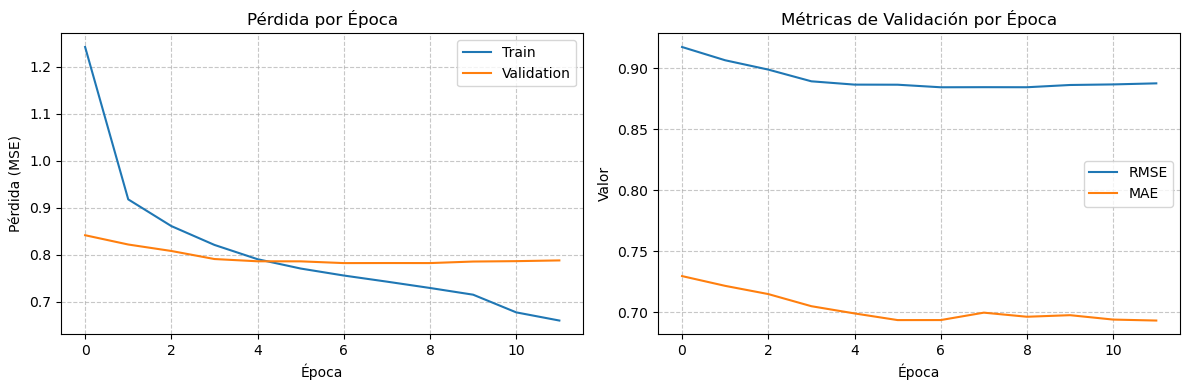

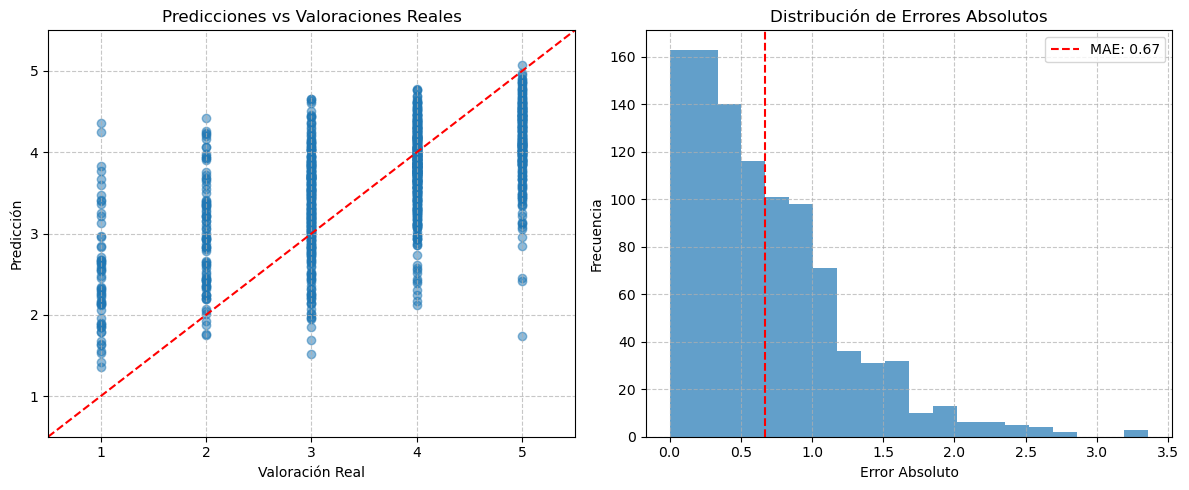

In [21]:
# Código para entrenar y evaluar el modelo de recomendación
# Optimizado para Apple Silicon



# Configurar hiperparámetros de entrenamiento
num_epochs = 20
early_stopping_patience = 5  # Número de épocas para esperar mejora antes de detener
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}

# Función para evaluar el modelo en el conjunto de validación o prueba
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Poner el modelo en modo evaluación
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Desactivar cálculo de gradientes
        for batch in data_loader:
            # Mover datos al dispositivo (CPU/MPS)
            users = batch['user'].to(device)
            movies = batch['movie'].to(device)
            ratings = batch['rating'].to(device)
            
            # Forward pass
            predictions = model(users, movies)
            loss = criterion(predictions, ratings)
            
            # Acumular pérdida
            total_loss += loss.item() * len(ratings)
            
            # Guardar predicciones y objetivos para métricas
            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(ratings.cpu().numpy())
    
    # Calcular métricas
    avg_loss = total_loss / len(data_loader.dataset)
    rmse = sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    
    return avg_loss, rmse, mae

print("Comenzando entrenamiento del modelo...")
start_time = time.time()

# Bucle principal de entrenamiento
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()  # Poner el modelo en modo entrenamiento
    train_loss = 0.0
    batch_count = 0
    
    for batch in train_loader:
        # Mover datos al dispositivo (CPU/MPS)
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings = batch['rating'].to(device)
        
        # Limpiar gradientes
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(users, movies)
        loss = criterion(predictions, ratings)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        # Acumular pérdida
        train_loss += loss.item() * len(ratings)
        batch_count += 1
        
        # Mostrar progreso cada 200 batches
        if batch_count % 200 == 0:
            print(f"  Época {epoch+1}/{num_epochs} - Batch {batch_count}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    # Calcular pérdida media de entrenamiento
    avg_train_loss = train_loss / len(train_loader.dataset)
    
    # Evaluar en conjunto de validación
    val_loss, val_rmse, val_mae = evaluate_model(model, val_loader, criterion, device)
    
    # Actualizar historial
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)
    
    # Actualizar learning rate scheduler
    scheduler.step(val_loss)
    
    # Imprimir resultados
    print(f"Época {epoch+1}/{num_epochs}:")
    print(f"  Pérdida entrenamiento: {avg_train_loss:.4f}")
    print(f"  Pérdida validación: {val_loss:.4f}")
    print(f"  RMSE validación: {val_rmse:.4f}")
    print(f"  MAE validación: {val_mae:.4f}")
    
    # Comprobación para early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Guardar el mejor modelo
        torch.save(model.state_dict(), 'best_model.pth')
        print("  Guardado nuevo mejor modelo")
    else:
        patience_counter += 1
        print(f"  No hay mejora en la pérdida de validación. Paciencia: {patience_counter}/{early_stopping_patience}")
        
        if patience_counter >= early_stopping_patience:
            print(f"¡Early stopping! No hay mejora durante {early_stopping_patience} épocas.")
            break

# Calcular tiempo total de entrenamiento
training_time = time.time() - start_time
print(f"Entrenamiento completado en {training_time/60:.2f} minutos")

# Cargar el mejor modelo para evaluación final
model.load_state_dict(torch.load('best_model.pth'))

# Evaluar en conjunto de prueba
test_loss, test_rmse, test_mae = evaluate_model(model, test_loader, criterion, device)
print("\nResultados en conjunto de prueba:")
print(f"  Pérdida (MSE): {test_loss:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")

# Visualizar progreso del entrenamiento
plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Pérdida por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico de métricas
plt.subplot(1, 2, 2)
plt.plot(history['val_rmse'], label='RMSE')
plt.plot(history['val_mae'], label='MAE')
plt.title('Métricas de Validación por Época')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('training_progress.png')
plt.show()

# Análisis de predicciones vs valores reales
def analyze_predictions(model, data_loader, device, num_samples=1000):
    model.eval()
    all_preds = []
    all_targets = []
    all_errors = []
    
    with torch.no_grad():
        for batch in data_loader:
            users = batch['user'].to(device)
            movies = batch['movie'].to(device)
            ratings = batch['rating'].to(device)
            
            predictions = model(users, movies)
            
            # Acumular datos
            predictions_np = predictions.cpu().numpy()
            ratings_np = ratings.cpu().numpy()
            
            all_preds.extend(predictions_np)
            all_targets.extend(ratings_np)
            all_errors.extend(np.abs(predictions_np - ratings_np))
            
            if len(all_preds) >= num_samples:
                break
    
    # Convertir a arrays de numpy y limitar al número de muestras
    all_preds = np.array(all_preds[:num_samples])
    all_targets = np.array(all_targets[:num_samples])
    all_errors = np.array(all_errors[:num_samples])
    
    # Visualizar predicciones vs valores reales
    plt.figure(figsize=(12, 5))
    
    # Gráfico de dispersión
    plt.subplot(1, 2, 1)
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.plot([0.5, 5.5], [0.5, 5.5], 'r--')  # Línea diagonal perfecta
    plt.xlim(0.5, 5.5)
    plt.ylim(0.5, 5.5)
    plt.title('Predicciones vs Valoraciones Reales')
    plt.xlabel('Valoración Real')
    plt.ylabel('Predicción')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Histograma de errores
    plt.subplot(1, 2, 2)
    plt.hist(all_errors, bins=20, alpha=0.7)
    plt.axvline(np.mean(all_errors), color='r', linestyle='--', label=f'MAE: {np.mean(all_errors):.2f}')
    plt.title('Distribución de Errores Absolutos')
    plt.xlabel('Error Absoluto')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('prediction_analysis.png')
    plt.show()

# Analizar predicciones en el conjunto de prueba
analyze_predictions(model, test_loader, device)